### Import Libraries

In [3]:
from collections import Counter, defaultdict
import datetime as dt
import os
import pickle
import re

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

### Data

In [4]:
data_path = os.path.join('/Users/krzysiekpilat/Desktop/MVP/', '1.Data set/')
companies_filename = 'companies.csv'
investors_filename = 'investor.csv'
output_filename = 'cleaned_ds.csv'

In [42]:
#Downland data
df = pd.read_csv(os.path.join(data_path, companies_filename))
investor =  pd.read_csv(os.path.join(data_path, investors_filename))
df.shape

/Users/krzysiekpilat/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (13,15,17,19,26,27,28,38,44,45,46,51,52,53,54,56,58,60,63,67,68,69,70,71,73,74,75,76,77,78,80,81,82,83,84,85,86,88,91,92,93,94,95,96,97,99,101,102,103,104,105,106,108,111,113,114,115,116) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/krzysiekpilat/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (2,5,9,54,55,56,58,59,113) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(498402, 118)

In [43]:
#Drop Duplication
df = df.loc[:,~df.columns.duplicated()].drop_duplicates()
investor = investor.loc[:,~investor.columns.duplicated()].drop_duplicates()
#Columns standarization
df.columns = df.columns.str.lower().str.strip().str.replace(' ','_')
investor.columns = investor.columns.str.lower().str.strip().str.replace(' ','_')
print(df.shape)
print(investor.shape)

(411467, 118)
(53409, 119)


### Mising data

In [44]:
#Check missing value
((df.notnull().sum().sort_values().head(5))/len(df))*100

accelerator_application_deadline    0.028921
accelerator_duration_(in_weeks)     0.029893
accelerator_program_type            0.033296
number_of_alumni                    0.060758
number_of_diversity_investments     0.061001
dtype: float64

(411467, 118)


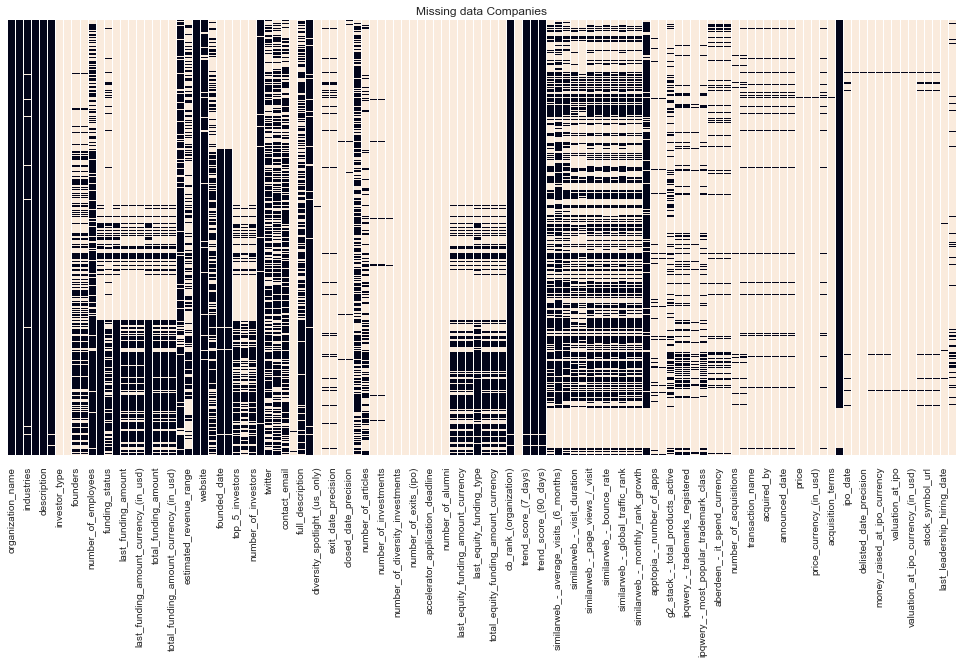

In [45]:
print(df.shape)
fig, ax = plt.subplots(figsize=(17,8))
ax = sns.heatmap(df.isnull(), cbar=False)
ax.set_yticks([])
ax.set_title("Missing data Companies")
plt.show()

In [184]:
#Drop columns with missing value <84% TODO rozpisz 
clean_df=df[df.columns[df.isnull().mean()<0.84]]

(411467, 63)


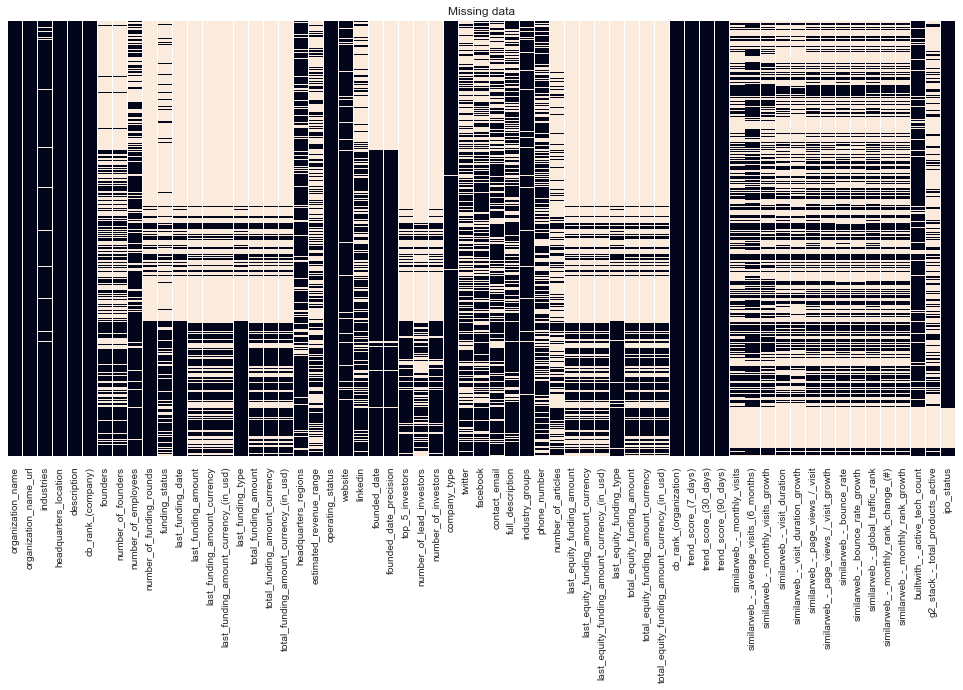

In [73]:
print(clean_df.shape)
fig, ax = plt.subplots(figsize=(17,8))
ax = sns.heatmap(clean_df.isnull(), cbar=False)
ax.set_yticks([])
ax.set_title("Missing data")
plt.show()

In [185]:
#Dropna columns
clean_df = clean_df.drop(columns = ['last_equity_funding_amount','last_equity_funding_amount_currency',
                                    'total_equity_funding_amount','total_equity_funding_amount_currency',
                                    'last_funding_amount','last_funding_amount_currency',
                                    'total_funding_amount','total_funding_amount_currency',
                                    'headquarters_regions','founded_date_precision','contact_email',
                                    'phone_number'])
#Check missing value
((clean_df.notnull().sum().sort_values().head(6))/len(clean_df))*100# 

number_of_lead_investors                         19.823704
last_equity_funding_amount_currency_(in_usd)     23.647826
total_equity_funding_amount_currency_(in_usd)    25.960041
last_funding_amount_currency_(in_usd)            26.312438
g2_stack_-_total_products_active                 26.337471
number_of_articles                               26.772013
dtype: float64

# Feature engineering

In [186]:
#General information
#Check missing value
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411467 entries, 0 to 491510
Data columns (total 51 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   organization_name                              411467 non-null  object 
 1   organization_name_url                          411467 non-null  object 
 2   industries                                     400853 non-null  object 
 3   headquarters_location                          411467 non-null  object 
 4   description                                    411456 non-null  object 
 5   cb_rank_(company)                              410603 non-null  object 
 6   founders                                       162157 non-null  object 
 7   number_of_founders                             162161 non-null  float64
 8   number_of_employees                            311544 non-null  object 
 9   number_of_funding_rounds             

### 0. Creat def to automate boring work :)

In [187]:
def norm_variable(dataset,column,head_number):
    top_titles = list(dataset[column].value_counts().head(head_number).keys())
    title_norm = defaultdict(lambda: 'other', dict(zip(top_titles, top_titles)))
    #dataset[column] = dataset[column].map(title_norm)
    dataset.loc[:, column] = dataset[column].map(title_norm)
    
def change(dataset, column, types):
    #dataset[column] = dataset[column].map(types)
    dataset.loc[:, column] = dataset[column].map(types)
    
def nany(dataset, column, value):
    #dataset[column] = dataset[column].fillna(value)
    dataset.loc[:, column] = dataset[column].fillna(value)

def money(dataset, column, labels, bins):
    #dataset[column] = pd.cut(dataset[column], bins, labels = labels,include_lowest = True)
    dataset.loc[:, column] =\
        pd.cut(dataset[column], bins, labels=labels, include_lowest = True)

def dates(dataset, column):
    #dataset[column] = pd.to_datetime(dataset[column],errors = 'coerce')
    dataset.loc[:, column] = pd.to_datetime(dataset[column], errors='coerce')

def coma(dataset, column):
    #dataset[column] = dataset[column].str.replace(',', '')
    dataset.loc[:, column] =\
        dataset[column].astype(str).str.replace(',', '')
    
def column_type(dataset, column, dtype):
    #dataset[column]=dataset[column].astype(str).astype(dtype)
    dataset.loc[:, column] = dataset[column].astype(str).astype(dtype)

In [188]:
industries = clean_df['industries'].str.split(', ',n=16,expand = True)
for number in range(16):
    clean_df['industries_'+ str(number+1)]=industries[number]

industries_group = clean_df['industry_groups'].str.split(', ',n=16,expand = True)
for number in range(16):
    clean_df['industries_group_'+ str(number+1)]=industries[number]

In [189]:
#location
new = clean_df['headquarters_location'].str.split(', ',n=4,expand =True)
# City
clean_df['n_city'] = new[0]
# Country
clean_df['n_country'] = new[2]

In [190]:
#Top 5 investor split for 5 new column
top = clean_df['top_5_investors'].str.split(', ',n=5,expand = True)

for number in range(5):
    clean_df['vc_' + str(number+1)]=top[number]

### 2. Normalize variable 

In [191]:
norm_variable(clean_df,'n_city', 20)
norm_variable(clean_df,'n_country', 20)

### 3. Funding Status change to numerical vari

In [192]:
#Column number of employees
number_of_emp={"1-10":1, "11-50":2, "51-100":3, "101-250":4, "251-500":5,"501-1000":6, "1001-5000":7,
               "10001+":8, "5001-10000":9}
change(clean_df,'number_of_employees',number_of_emp)

#Column funding status
funding_sta = {"Seed":1, "M&A ":2, "Early Stage Venture":3, "Late Stage Venture":4, "Private Equity":5, "IPO":6}
change(clean_df,'funding_status',funding_sta)

#Column Last Funding Type
last_fund_type={"Venture - Series Unknown":1,"Grant":2,"Angel":3,"Pre-Seed":4,"Seed":5,
       "Series A":6,"Series B":7,"Series C":8,"Series D":9,"Series E":10,
       "Series F":11,"Series G":12,"Series H":13,"Series I":14,"Series J":15,
      "Debt Financing":16,"Corporate Round":17,"Private Equity":18,"Convertible Note":19,
      "Equity Crowdfunding":20,"Post-IPO Equity":21,"Funding Round":22,"Non-equity Assistance":23,
      "Post-IPO Debt":24,"Secondary Market":25,"Product Crowdfunding":26,
       "Initial Coin Offering":27,"Post-IPO Secondary":28}
change(clean_df,'last_funding_type',last_fund_type) 

#Column estimated revenue range
revenu_range={"Less than $1M":1, "$1M to $10M":2, "$10M to $50M":3,"$100M to $500M":4,
       "$50M to $100M":5,"$1B to $10B":6,"$500M to $1B":7,"$10B+":8}
change(clean_df,'estimated_revenue_range',revenu_range) 

#Column vc_1 to vc_5
vc=investor[['organization/person_name','cb_rank_(investor)']].drop_duplicates()
vc['cb_rank_(investor)'] = vc['cb_rank_(investor)'].str.replace(',','')
vc = pd.Series(vc['cb_rank_(investor)'].values,index=vc['organization/person_name']).to_dict()
vcs=['vc_1','vc_2','vc_3','vc_4','vc_5']

for v in vcs:
    change(clean_df,v,vc)
    
#Columns industries_1 
ind = clean_df[['industries_1','total_funding_amount_currency_(in_usd)']]
ind['industries_total_funding_mln_usd'] = round((ind.groupby('industries_1')
                                                 ['total_funding_amount_currency_(in_usd)'].transform('sum'))/1000000,2)
industries = ind[['industries_1','industries_total_funding_mln_usd']].drop_duplicates()
industries = pd.Series(industries['industries_total_funding_mln_usd'].values,
                       index=industries['industries_1']).to_dict()
industry=['industries_1','industries_2','industries_3','industries_4','industries_5','industries_6','industries_7',
         'industries_8','industries_9','industries_10','industries_11','industries_12','industries_13','industries_14',
         'industries_15','industries_16']
for i in industry:
    change(clean_df,i,industries)
    
#Columns industries_group_1 
ind_group = clean_df[['industries_group_1','total_funding_amount_currency_(in_usd)']]
ind_group['industries_total_funding_mln_usd'] = round((ind_group.groupby('industries_group_1')
                                                 ['total_funding_amount_currency_(in_usd)'].transform('sum'))/1000000,2)
industries = ind_group[['industries_group_1','industries_total_funding_mln_usd']].drop_duplicates()
industries = pd.Series(industries['industries_total_funding_mln_usd'].values,
                       index=industries['industries_group_1']).to_dict()
industry_group=['industries_group_1','industries_group_2','industries_group_3','industries_group_4',
                'industries_group_5','industries_group_6','industries_group_7','industries_group_8',
               'industries_group_9','industries_group_10','industries_group_11','industries_group_12',
               'industries_group_13','industries_group_14','industries_group_15','industries_group_16']
for i in industry_group:
    change(clean_df,i,industries)

#Column operating status
op_status = {"Active":1,"Closed":0}
change(clean_df,'operating_status',op_status)

#Column company type
company_type = {"For Profit":1, "Non-profit":0}
change(clean_df,'company_type',company_type)

#last_equity_funding_type
last_equity_type={"Venture - Series Unknown":1,"Grant":2,"Angel":3,"Pre-Seed":4,"Seed":5,
       "Series A":6,"Series B":7,"Series C":8,"Series D":9,"Series E":10,
       "Series F":11,"Series G":12,"Series H":13,"Series I":14,"Series J":15,
      "Debt Financing":16,"Corporate Round":17,"Private Equity":18,"Convertible Note":19,
      "Equity Crowdfunding":20,"Post-IPO Equity":21,"Funding Round":22,"Non-equity Assistance":23,
      "Post-IPO Debt":24,"Secondary Market":25,"Product Crowdfunding":26,
       "Initial Coin Offering":27,"Post-IPO Secondary":28}
change(clean_df,'last_equity_funding_type',last_equity_type)

#ipo_status
type_company = {'Delisted':1,'Private':2,'Public':3}
change(clean_df,'ipo_status',type_company)

#n_city
city = {'other':0,'London':1,'New York':2,'San Francisco':3,'Tokyo':4,'Los Angeles':5,'Singapore':6,'Paris':7,
        'Beijing':8,'Chicago':9,'Berlin':10,'Mumbai':11,'Bangalore':12,'Austin':13,'New Delhi':14,'Boston':15,
        'Madrid':16,'Seattle':17,'Shanghai':18,'Tel Aviv':19,'San Diego':20}
change(clean_df,'n_city',city)

#n_country
country = {'other':0,'United States':1,'United Kingdom':2,'India':3,'China':4,'Germany':5,'France':6,'Spain':7,
           'Japan':8,'The Netherlands':9,'Israel':10,'Sweden':11,'Singapore':12,'Switzerland':13,'South Korea':14,
           'Italy':15,'Ireland':16,'Indonesia':17,'Hong Kong:':18,'Finland':19,'Denmark':20}
change(clean_df,'n_country',country)


/Users/krzysiekpilat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/krzysiekpilat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 4. Change to datetime 

In [193]:
dates(clean_df,'last_funding_date')
dates(clean_df,'founded_date')

### 5. Change NaN to difrent value

In [177]:
#General company information
nany(clean_df,'number_of_articles',0)
nany(clean_df,'cb_rank_(company)',0)
nany(clean_df,'industries','no_info')
nany(clean_df,'description','no_description')
nany(clean_df,'estimated_revenue_range',0)
nany(clean_df,'full_description','no_dscription')
nany(clean_df,'ipo_status',0)
nany(clean_df,'company_type',0)
nany(clean_df,'cb_rank_(organization)',0)
nany(clean_df,'n_country',0)
nany(clean_df,'n_city',0)

#Team
nany(clean_df,'founders','no_info')
nany(clean_df,'number_of_founders', 0)
nany(clean_df,'number_of_employees',0)

#funding
nany(clean_df,'number_of_funding_rounds',0)
nany(clean_df,"funding_status",0)
nany(clean_df,'last_funding_amount_currency_(in_usd)',0)
nany(clean_df,'last_funding_type', 0)
nany(clean_df,'total_funding_amount_currency_(in_usd)',0)
nany(clean_df,'number_of_lead_investors',0)
nany(clean_df,'number_of_investors',0)
nany(clean_df,'last_equity_funding_amount_currency_(in_usd)',0)
nany(clean_df,'total_equity_funding_amount_currency_(in_usd)',0)
nany(clean_df,'last_equity_funding_type',0)

#Date
nany(clean_df,'last_funding_date','1700-01-01')
nany(clean_df,'founded_date','1700-01-01')

#Industries
industry=['industries_1','industries_2','industries_3','industries_4','industries_5','industries_6','industries_7',
         'industries_8','industries_9','industries_10','industries_11','industries_12','industries_13','industries_14',
         'industries_15','industries_16']
for i in industry:
    nany(clean_df,i,0)
    
industry_group=['industries_group_1','industries_group_2','industries_group_3','industries_group_4',
                'industries_group_5','industries_group_6','industries_group_7','industries_group_8',
               'industries_group_9','industries_group_10','industries_group_11','industries_group_12',
               'industries_group_13','industries_group_14','industries_group_15','industries_group_16']
for i in industry_group:
    nany(clean_df,i,0)

#Vc
vcs=['vc_1','vc_2','vc_3','vc_4','vc_5']

for v in vcs:
    nany(clean_df,v,0)

#Similarweb
nany(clean_df,'similarweb_-_visit_duration_growth',0)

nany(clean_df,'similarweb_-_visit_duration',0)
nany(clean_df,'similarweb_-_bounce_rate_growth',0)
nany(clean_df,'similarweb_-_monthly_rank_change_(#)',0)
nany(clean_df,'similarweb_-_monthly_rank_growth',0)
nany(clean_df,'similarweb_-_page_views_/_visit_growth',0)
nany(clean_df,'similarweb_-_bounce_rate',0)
nany(clean_df,'similarweb_-_global_traffic_rank',0)
nany(clean_df,'similarweb_-_monthly_visits',0)
nany(clean_df,'similarweb_-_page_views_/_visit',0)
nany(clean_df,'similarweb_-_monthly_visits_growth',0)
nany(clean_df,'similarweb_-_average_visits_(6_months)',0)

#Other
nany(clean_df,'g2_stack_-_total_products_active',0)
nany(clean_df,'builtwith_-_active_tech_count',0)
nany(clean_df,'trend_score_(90_days)',0)
nany(clean_df,'trend_score_(30_days)',0)
nany(clean_df,'trend_score_(7_days)',0)

### 6. Change column type

In [178]:
#number_of_articles
coma(clean_df,'number_of_articles')
column_type(clean_df,'number_of_articles', dtype=float)

#cb_rank(company)
coma(clean_df,'cb_rank_(company)')
column_type(clean_df,'cb_rank_(company)', dtype=float)

#g2_stack_
coma(clean_df,'g2_stack_-_total_products_active')
column_type(clean_df,'g2_stack_-_total_products_active', dtype=float)

#vc_
for v in vcs:
    column_type(clean_df,v, dtype=int)

### 7. Drop Outlire

TypeError: '<=' not supported between instances of 'float' and 'str'

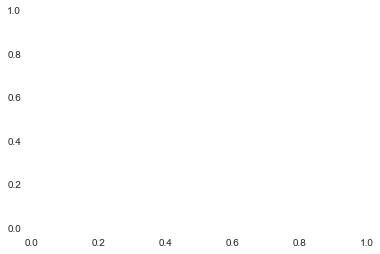

In [194]:
column = 'vc_1'
plt.hist(clean_df.loc[:, column], bins=30)
plt.title(column)
plt.show()

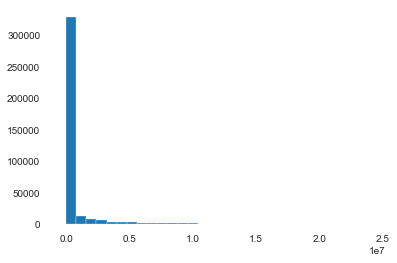

In [180]:
colimn = 'last_funding_amount_currency_(in_usd)'
max_treshold = clean_df[column].quantile(0.95)
    
clean_df = clean_df[(clean_df[column]<max_treshold)]
plt.hist(clean_df.loc[:, column], bins=30)
plt.show()

### 7. Droping column

In [47]:
#Dropna columns
clean_df = clean_df.drop(columns = ['industries','top_5_investors','headquarters_location','industry_groups','linkedin',
                                   'website','twitter','facebook','description','organization_name_url','founders',
                                    'full_description','industries_6','industries_6','industries_7','industries_8'
                                    ,'industries_9','industries_10','industries_11','industries_12','industries_13'
                                    ,'industries_14','industries_15','industries_16','industries_group_1',
                                    'industries_group_2','industries_group_3', 'industries_group_4','industries_group_5',
                                    'industries_group_6','industries_group_7','industries_group_8','industries_group_9',
                                    'industries_group_10','industries_group_11','industries_group_12','industries_group_13',
                                    'industries_group_14','industries_group_15','industries_group_16'])
#Check missing value
((clean_df.notnull().sum().sort_values().head(6))/len(clean_df))*100#

organization_name                         100.0
similarweb_-_visit_duration               100.0
similarweb_-_visit_duration_growth        100.0
similarweb_-_page_views_/_visit           100.0
similarweb_-_page_views_/_visit_growth    100.0
similarweb_-_bounce_rate                  100.0
dtype: float64

In [196]:
clean_df["vc_1"].value_counts(dropna=False)

NaN       295183
1512        4403
38114       2875
67          2625
248         1717
           ...  
1451           1
94669          1
102723         1
126253         1
92297          1
Name: vc_1, Length: 15882, dtype: int64

In [152]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115352 entries, 177121 to 491457
Data columns (total 90 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   organization_name                              115352 non-null  object 
 1   organization_name_url                          115352 non-null  object 
 2   industries                                     115352 non-null  object 
 3   headquarters_location                          115352 non-null  object 
 4   description                                    115352 non-null  object 
 5   cb_rank_(company)                              115352 non-null  float64
 6   founders                                       115352 non-null  object 
 7   number_of_founders                             115352 non-null  float64
 8   number_of_employees                            115352 non-null  float64
 9   number_of_funding_rounds        

In [49]:
clean_df.to_csv(os.path.join(data_path, output_filename))